In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 100  
VOLUME_SLICES = 5 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [3]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

In [4]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

## Data Generators

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data

        ## TO DO : MEASURE DOMAIN SHIFT

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1.nii');
            t1 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


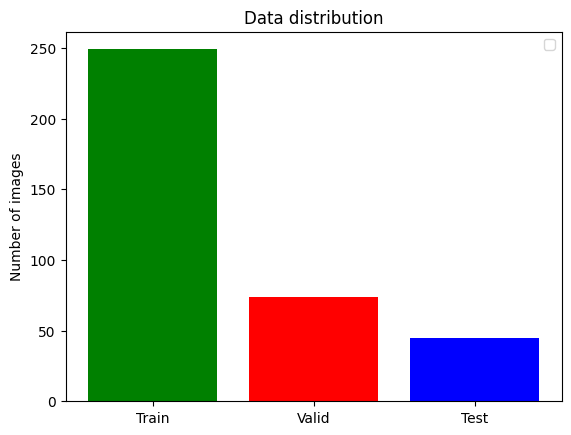

In [6]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [7]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [ ]:
# K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=2,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )

# model.save("model_x1_1.h5")

In [11]:
############ load trained model ################
target_model = keras.models.load_model('model_x1_1.h5',
                                  compile=False)

n_frozen_layers = 25

# Freeze initial layers in the target model (total = 37)
for layer in target_model.layers[:n_frozen_layers]:
    layer.trainable = False


In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
tf.profiler.experimental.start('logs-tl2')

In [13]:
# Freeze initial layers (assuming the first few layers are the encoder)
for layer in target_model.layers[:n_frozen_layers]:
    layer.trainable = False

# Example code for training on target modalities
target_data_generator = training_generator  # Define your data generator for target modalities
# target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
target_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
target_model.fit(target_data_generator, epochs=5)

Epoch 1/5
249/249 [==============================] - 149s 590ms/step - loss: 0.0019 - accuracy: 0.9999 - precision: 0.9999 - sensitivity: 0.9999 - specificity: 1.0000 - dice_coef_necrotic: 2.7550e-06 - dice_coef_edema: 5.4942e-06 - dice_coef_enhancing: 5.4614e-07
Epoch 2/5
249/249 [==============================] - 143s 576ms/step - loss: 0.0017 - accuracy: 0.9999 - precision: 0.9999 - sensitivity: 0.9999 - specificity: 1.0000 - dice_coef_necrotic: 5.6050e-07 - dice_coef_edema: 2.7733e-05 - dice_coef_enhancing: 2.9044e-06
Epoch 3/5
249/249 [==============================] - 140s 561ms/step - loss: 0.0044 - accuracy: 0.9999 - precision: 0.9999 - sensitivity: 0.9999 - specificity: 1.0000 - dice_coef_necrotic: 6.2740e-05 - dice_coef_edema: 1.5862e-05 - dice_coef_enhancing: 2.5559e-10
Epoch 4/5
249/249 [==============================] - 142s 570ms/step - loss: 0.0018 - accuracy: 0.9999 - precision: 0.9999 - sensitivity: 0.9999 - specificity: 1.0000 - dice_coef_necrotic: 1.9265e-06 - dice_c

In [14]:
tf.profiler.experimental.stop()